<a href="https://colab.research.google.com/github/teethavattcp/teethavat_port_data/blob/main/02_Price2DemandElasticity_RevisedAspect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Price Elasticity on Demand

# Import dataset

https://drive.google.com/file/d/1YdnAe0EJsSHOi6rSIJ5p0ef_sySo0MKb/view?usp=drive_link

In [ ]:
import os

In [ ]:
import time

In [ ]:
!gdown https://drive.google.com/uc?id=1YdnAe0EJsSHOi6rSIJ5p0ef_sySo0MKb

Downloading...
From (original): https://drive.google.com/uc?id=1YdnAe0EJsSHOi6rSIJ5p0ef_sySo0MKb
From (redirected): https://drive.google.com/uc?id=1YdnAe0EJsSHOi6rSIJ5p0ef_sySo0MKb&confirm=t&uuid=2636673a-96ec-4170-8842-7fd419f38f81
To: /content/dunnhumby_The-Complete-Journey CSV.zip
100% 134M/134M [00:01<00:00, 82.9MB/s]


In [ ]:
if os.path.exists("/content/Dataset/dunnhumby_The-Complete-Journey CSV"):
  print('The files are already existed.')
else:
  !unzip "/content/dunnhumby_The-Complete-Journey CSV.zip" -d "Dataset"

Archive:  /content/dunnhumby_The-Complete-Journey CSV.zip
  inflating: Dataset/dunnhumby_The-Complete-Journey CSV/campaign_desc.csv  
  inflating: Dataset/dunnhumby_The-Complete-Journey CSV/campaign_table.csv  
  inflating: Dataset/dunnhumby_The-Complete-Journey CSV/causal_data.csv  
  inflating: Dataset/dunnhumby_The-Complete-Journey CSV/coupon.csv  
  inflating: Dataset/dunnhumby_The-Complete-Journey CSV/coupon_redempt.csv  
  inflating: Dataset/dunnhumby_The-Complete-Journey CSV/hh_demographic.csv  
  inflating: Dataset/dunnhumby_The-Complete-Journey CSV/product.csv  
  inflating: Dataset/dunnhumby_The-Complete-Journey CSV/transaction_data.csv  


# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [ ]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=69d06768a91702fe904a537a29cef036288fc571855d5a88c2d3ac2bc9e35018
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
import pandasql

In [ ]:
import plotly.express as px

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

In [ ]:
import datetime as dt
from datetime import datetime

In [ ]:
from pathlib import Path

## Spark Preparation

In [ ]:
# Install pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=bb470579884bb1c394b263bf9d344f29ebb69f5a685c9952f2b3c3e64a0d8949
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [ ]:
# Import a Spark function from library
from pyspark.sql.functions import col

### Start a Local Cluster
Use findspark.init() to start a local cluster. If you plan to use remote cluster, skip the findspark.init() and change the cluster_url according.

In [ ]:
!pip install findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
cluster_url = 'local'

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder\
        .master(cluster_url)\
        .appName('SparkSQL')\
        .getOrCreate()

In [ ]:
from pyspark.sql.functions import avg, min, max, countDistinct

#Define functions

## dict_k2v_v2k(input_dict):

In [ ]:
def dict_k2v_v2k(input_dict):
  output_dict = {}

  for data_type, columns in input_dict.items():
    for column in columns:
        output_dict[column] = data_type

  return output_dict

## check_shape_in_df_spark(df)

In [ ]:
def check_shape_in_df_spark(df):
  print('Shape of dataframe:')
  print(f'#rows: {df.count()}')
  print(f'#columns: {len(df.columns)}')

## explore_classes_in_df(df, list_of_attributes)

This function will print the unique values and their counts for each categorical column in the list df_col_cat.

In [ ]:
def explore_classes_in_df(df, list_of_attributes):
    for col in list_of_attributes:
        print(f"\n-------- {col} --------")

        # Perform groupBy and count operations
        result = df.groupBy(col).count().orderBy("count", ascending=False)

        # Show results
        result.show(truncate=False)

In [ ]:
# Sample DataFrame
data_sample = [("Alice", "A"), ("Bob", "B"), ("Alice", "A"), ("Charlie", "B"), ("Bob", "A")]
columns_sample = ["name", "category"]

df_sample = spark.createDataFrame(data_sample, columns_sample)

# List of categorical columns
df_col_cat_sample = ["category"]

# Call the function
explore_classes_in_df(df_sample, df_col_cat_sample)


-------- category --------
+--------+-----+
|category|count|
+--------+-----+
|A       |3    |
|B       |2    |
+--------+-----+



## get_columnvalues_as_list(df, column_name,is_distinct={1,0})

To retrieve values from a column of a PySpark DataFrame and return them as a list

In [ ]:
def get_columnvalues_as_list(df, column_name, is_distinct):
    # Collect the column values into a list of Row objects
    rows = df.select(column_name).collect()

    # Extract the column values from the Row objects
    column_values = [row[column_name] for row in rows]

    # Get distinct values by converting the list to a set
    if is_distinct == 1:
        column_values = list(set(column_values))

    # Sort alphabetically
    column_values.sort()
    return column_values

In [ ]:
get_columnvalues_as_list(df_sample, "name",is_distinct=1)

['Alice', 'Bob', 'Charlie']

## export_sparkdf_to_csv(spark_df, path_of_folder, file_name)

In [ ]:
def export_sparkdf_to_csv(spark_df, path_of_folder, file_name):
    # Create a Spark session if it doesn't exist
    spark = SparkSession.builder.getOrCreate()

    # Define the full path for the output CSV file
    filepath = Path(path_of_folder) / (file_name + '.csv')

    # Ensure the directory exists
    filepath.parent.mkdir(parents=True, exist_ok=True)

    # Write the Spark DataFrame to CSV
    spark_df.write.mode('overwrite').csv(str(filepath), header=True)

    print(f'{file_name}.csv has been exported successfully.')

## export_pandasdf_to_csv(df,path_of_folder,file_name)

In [ ]:
def export_pandasdf_to_csv(df,path_of_folder,file_name):
  filepath = Path(str(path_of_folder)+str(file_name)+'.csv')
  filepath.parent.mkdir(parents=True, exist_ok=True)
  df.to_csv(filepath,mode = 'w', index=False)
  print(str(file_name)+'.csv has been exported successfully.')

## find_common_elements_in_list(list1, list2)

In [ ]:
def find_common_elements_in_list(list1, list2):
    # Convert lists to sets
    set1 = set(list1)
    set2 = set(list2)

    # Find intersection of sets
    common_elements = set1.intersection(set2)

    # Convert the result back to a list
    return list(common_elements)

# Prepare data for being processed by Spark

Given dataset as aggregation of Produdct_ID and Cust_paid_priuce

In [ ]:
df_fact_trans = spark.read.option("delimiter", ",").option("header", True).csv('/content/drive/MyDrive/DATA_SCI_SKILL/202406_CompleteJourneyProj/data set/fact_trans_x_couponredempt.csv')
cols = [c.replace('.', '_') for c in df_fact_trans.columns]
df_fact_trans = df_fact_trans.toDF(*cols)
df_fact_trans.show(5)

+-------------+-----------+---+------------+--------+-----------+--------+-----------+----------+-------+-----------+-----------------+----------+------------------------+-------------------+----------------------+-----------------+---------------+----------+
|household_key|  BASKET_ID|DAY|PRODUCT_ID_x|QUANTITY|SALES_VALUE|STORE_ID|RETAIL_DISC|TRANS_TIME|WEEK_NO|COUPON_DISC|COUPON_MATCH_DISC|TOTAL_DISC|If_used_retail_loyalprog|If_used_manu_coupon|If_used_giveaway_promo|Actual_card_price|Cust_paid_price|COUPON_UPC|
+-------------+-----------+---+------------+--------+-----------+--------+-----------+----------+-------+-----------+-----------------+----------+------------------------+-------------------+----------------------+-----------------+---------------+----------+
|            1|27601281299| 51|      825123|       1|       3.99|     436|        0.0|      1456|      8|        0.0|              0.0|       0.0|                       0|                  0|                     0|      

In [ ]:
df_fact_trans_data = df_fact_trans.select(df_fact_trans['PRODUCT_ID_x'],df_fact_trans['Cust_paid_price'],df_fact_trans['QUANTITY'])
df_fact_trans_data = df_fact_trans_data.withColumnRenamed('PRODUCT_ID_x','PRODUCT_ID')
df_fact_trans_data.show(5)

+----------+---------------+--------+
|PRODUCT_ID|Cust_paid_price|QUANTITY|
+----------+---------------+--------+
|    825123|           3.99|       1|
|    831447|           2.99|       1|
|    840361|           1.09|       1|
|    845307|           3.71|       1|
|    852014|           2.79|       1|
+----------+---------------+--------+
only showing top 5 rows



In [ ]:
df_fact_trans_data.describe().show()

+-------+------------------+------------------+------------------+
|summary|        PRODUCT_ID|   Cust_paid_price|          QUANTITY|
+-------+------------------+------------------+------------------+
|  count|           2581266|           2581266|           2581266|
|   mean| 2880987.442369752|2.4470828428970224| 100.9913825231495|
| stddev|3837941.2236042344|2.7335314987769697|1156.6391844912364|
|    min|           1000002|               0.0|                 1|
|    max|            999992|             99.99|              9997|
+-------+------------------+------------------+------------------+



To perform elasticity analysis which is analyzing how quantity responds to price changes (understand the typical quantity sold at each price point), aggregating by **average** quantity per price point is generally more appropriate.
- The average gives a representative measure of the quantity sold (demand) when the price is fixed, smoothing out variations due to different purchase occasions or transactions.
- **The standard deviation of quantity is very high compared to the mean**, indicating substantial **variability in quantity**. This suggests that there are some very large quantities relative to the average, which might skew certain analyses.

## Assign data type to each column

In [ ]:
cols_num = ['Cust_paid_price','QUANTITY']
for c in cols_num:
    df_fact_trans_data = df_fact_trans_data.withColumn(c, col(c).cast('double'))

In [ ]:
df_fact_trans_data = df_fact_trans_data.withColumn('PRODUCT_ID', col('PRODUCT_ID').cast('int'))

In [ ]:
df_fact_trans_data.printSchema()

root
 |-- PRODUCT_ID: integer (nullable = true)
 |-- Cust_paid_price: double (nullable = true)
 |-- QUANTITY: double (nullable = true)



In [ ]:
#Check number of rows
df_fact_trans_data.count()

2581266

#Labeling demand elasticity for each product_id

Use EDA to filter out Perfectly Elastic category and later estimate elasticity through simple linear regression slope to reduce processing time.
Furthurmore,  For analysis using simple linear regression in price[x]-demand[y] elasticity analysis, there is the assumption that for each unique value of (x), there is a single corresponding value of (y). In other words, we can return result of elasticity without modeling but from EDA relevant by theory.

## 0) Unknown elasticity pattern

Filter product_id having only 1 point of qty and price

In [ ]:
df_fact_trans_data.createOrReplaceTempView("fact_trans_data")

###[0] Product_ID with 1 record

#### df_unknown_elasticity_1

In [ ]:
df_unknown_elasticity_0 = spark.sql('''
    WITH product_with_one_record AS(
      SELECT
        PRODUCT_ID,
        COUNT(Cust_paid_price) AS Record_count
      FROM
        fact_trans_data
      GROUP BY
        PRODUCT_ID
      HAVING
        COUNT(Cust_paid_price) = 1
    )

    SELECT
        PRODUCT_ID,
        Cust_paid_price,
        QUANTITY,
        COUNT(QUANTITY) AS record_count
    FROM
        fact_trans_data
    GROUP BY
        PRODUCT_ID, Cust_paid_price, QUANTITY
    HAVING
        PRODUCT_ID IN (SELECT DISTINCT PRODUCT_ID FROM product_with_one_record)
    ORDER BY PRODUCT_ID, Cust_paid_price, QUANTITY
''')
df_unknown_elasticity_0.show()

+----------+---------------+--------+------------+
|PRODUCT_ID|Cust_paid_price|QUANTITY|record_count|
+----------+---------------+--------+------------+
|     26081|           0.99|     1.0|           1|
|     26093|           1.59|     1.0|           1|
|     26190|           1.54|     1.0|           1|
|     26355|           0.99|     2.0|           1|
|     26426|           2.29|     1.0|           1|
|     26601|           7.59|     1.0|           1|
|     26636|            2.5|     1.0|           1|
|     26738|           2.75|     1.0|           1|
|     26889|           4.99|     1.0|           1|
|     26941|            1.0|     1.0|           1|
|     27030|           2.15|     2.0|           1|
|     27152|           1.98|     1.0|           1|
|     27160|           1.92|     1.0|           1|
|     27323|           2.69|     1.0|           1|
|     27346|           0.99|     1.0|           1|
|     27404|           1.99|     1.0|           1|
|     27491|           4.99|   

In [ ]:
spark.sql('''
    WITH product_with_one_record AS(
      SELECT
        PRODUCT_ID,
        COUNT(Cust_paid_price) AS Record_count
      FROM
        fact_trans_data
      GROUP BY
        PRODUCT_ID
      HAVING
        COUNT(Cust_paid_price) = 1
    )

    SELECT
        PRODUCT_ID,
        Cust_paid_price,
        COUNT(QUANTITY) AS record_count
    FROM
        fact_trans_data
    GROUP BY
        PRODUCT_ID, Cust_paid_price
    HAVING
        PRODUCT_ID IN (SELECT DISTINCT PRODUCT_ID FROM product_with_one_record)
    ORDER BY record_count DESC
''').show()

+----------+---------------+------------+
|PRODUCT_ID|Cust_paid_price|record_count|
+----------+---------------+------------+
|    389959|           3.51|           1|
|   6602315|           4.49|           1|
|    756288|           1.39|           1|
|    427308|           3.15|           1|
|   9798185|           4.29|           1|
|    865428|           2.99|           1|
|   1235982|           1.67|           1|
|  15478158|           11.3|           1|
|   1973566|          23.99|           1|
|  12517698|           1.88|           1|
|  15716393|           2.59|           1|
|  12605283|           3.49|           1|
|   6395998|           1.19|           1|
|  16828772|           2.99|           1|
|   9469393|           7.99|           1|
|    741050|           2.79|           1|
|    439658|           0.99|           1|
|   1015898|           2.69|           1|
|   1114295|           4.35|           1|
|    952723|           1.88|           1|
+----------+---------------+------

In [ ]:
spark.sql('''
    WITH product_with_one_record AS(
      SELECT
        PRODUCT_ID,
        COUNT(Cust_paid_price) AS Record_count
      FROM
        fact_trans_data
      GROUP BY
        PRODUCT_ID
      HAVING
        COUNT(Cust_paid_price) = 1
    )

    SELECT
        PRODUCT_ID,
        QUANTITY,
        COUNT(Cust_paid_price) AS record_count
    FROM
        fact_trans_data
    GROUP BY
        PRODUCT_ID, QUANTITY
    HAVING
        PRODUCT_ID IN (SELECT DISTINCT PRODUCT_ID FROM product_with_one_record)
    ORDER BY record_count DESC
''').show()

+----------+--------+------------+
|PRODUCT_ID|QUANTITY|record_count|
+----------+--------+------------+
|    965804|     1.0|           1|
|  16809173|     1.0|           1|
|   2600176|     1.0|           1|
|   9364316|     1.0|           1|
|   1308283|     1.0|           1|
|   1573412|     2.0|           1|
|   1714571|     1.0|           1|
|   1514712|     1.0|           1|
|  12671011|     1.0|           1|
|   1707991|     1.0|           1|
|  17901003|     2.0|           1|
|  13038819|     1.0|           1|
|   1936789|     1.0|           1|
|   5665755|     1.0|           1|
|   9550176|     1.0|           1|
|  12730591|     2.0|           1|
|  17903416|     1.0|           1|
|     29512|     1.0|           1|
|     66371|     1.0|           1|
|  12432208|     1.0|           1|
+----------+--------+------------+
only showing top 20 rows



In [ ]:
check_shape_in_df_spark(df_unknown_elasticity_0)

Shape of dataframe:
#rows: 33542
#columns: 4


####Finding: 33542 records

In [ ]:
df_unknown_elasticity_0.describe().show()

+-------+-----------------+-----------------+-----------------+------------+
|summary|       PRODUCT_ID|  Cust_paid_price|         QUANTITY|record_count|
+-------+-----------------+-----------------+-----------------+------------+
|  count|            33542|            33542|            33542|       33542|
|   mean|5862114.203804186|4.397076136387406|3.050116272136426|         1.0|
| stddev|5481471.104118625|7.360430283271176| 161.357395122785|         0.0|
|    min|            26081|              0.0|              1.0|           1|
|    max|         18316298|           499.99|          18559.0|           1|
+-------+-----------------+-----------------+-----------------+------------+



#####product_unknown_elasticity_0 [list]

In [ ]:
product_unknown_elasticity_0 = get_columnvalues_as_list(df_unknown_elasticity_0,'PRODUCT_ID',1)
len(product_unknown_elasticity_0)

33542

###[2] One (distinct) price for the product across all qty sold records

In [ ]:
spark.sql('''
    WITH product_with_one_qty AS(
      SELECT
        PRODUCT_ID,
        COUNT(DISTINCT QUANTITY) AS QTY_grpcountD,
        COUNT(QUANTITY) AS Record_count
      FROM
        fact_trans_data
      GROUP BY
        PRODUCT_ID
      HAVING
        COUNT(DISTINCT QUANTITY) = 1 AND COUNT(QUANTITY) > 1
    )

    SELECT
        PRODUCT_ID,
        QUANTITY,
        COUNT(DISTINCT Cust_paid_price) AS Price_grpcountD,
        COUNT(Cust_paid_price) AS Record_count
    FROM
        fact_trans_data
    GROUP BY
        PRODUCT_ID, QUANTITY
    HAVING
        PRODUCT_ID IN (SELECT PRODUCT_ID FROM product_with_one_qty)
''').show()

+----------+--------+---------------+------------+
|PRODUCT_ID|QUANTITY|Price_grpcountD|Record_count|
+----------+--------+---------------+------------+
|   1136715|     1.0|             45|          53|
|  15596457|     1.0|              1|           3|
|    845098|     1.0|              1|           4|
|   9527048|     1.0|              3|           3|
|    839006|     1.0|              8|           8|
|    821184|     1.0|              4|          18|
|    995436|     1.0|             20|          29|
|  13416097|     1.0|              2|           3|
|  15716478|     1.0|              1|           4|
|    953447|     1.0|              2|           7|
|    904521|     1.0|              9|          97|
|    922610|     1.0|              3|           6|
|  13007354|     1.0|              5|          15|
|  15452302|     1.0|             11|          11|
|   9420275|     1.0|              2|           2|
|   1132036|     1.0|              8|         145|
|    954291|     1.0|          

####Finding:
From the observing scenario, there are (COUNT(DISTINCT Price) = 1 and constant quantity sold), **it cannot be concluded as perfectly inelastic demand** because it lacks price variation needed to assess the relationship between price and quantity demanded.

Thus, it should be classified as "Unknown" elasticity

In [ ]:
df_unknown_elasticity_1 = spark.sql('''
    WITH product_with_one_qty AS(
      SELECT
        PRODUCT_ID,
        COUNT(DISTINCT QUANTITY) AS QTY_grpcountD,
        COUNT(QUANTITY) AS Record_count
      FROM
        fact_trans_data
      GROUP BY
        PRODUCT_ID
      HAVING
        COUNT(DISTINCT QUANTITY) = 1 AND COUNT(QUANTITY) > 1
    )

    SELECT
        PRODUCT_ID,
        QUANTITY,
        COUNT(DISTINCT Cust_paid_price) AS Price_grpcountD,
        COUNT(Cust_paid_price) AS Record_count
    FROM
        fact_trans_data
    GROUP BY
        PRODUCT_ID, QUANTITY
    HAVING
        PRODUCT_ID IN (SELECT PRODUCT_ID FROM product_with_one_qty) AND Price_grpcountD = 1
''')
df_unknown_elasticity_1.show()

+----------+--------+---------------+------------+
|PRODUCT_ID|QUANTITY|Price_grpcountD|Record_count|
+----------+--------+---------------+------------+
|  15596457|     1.0|              1|           3|
|    845098|     1.0|              1|           4|
|  15716478|     1.0|              1|           4|
|    954291|     1.0|              1|           2|
|   5590354|     1.0|              1|          15|
|   1101628|     1.0|              1|           5|
|  16829183|     1.0|              1|           2|
|   1042354|     1.0|              1|           2|
|   1030303|     1.0|              1|           2|
|   8090775|     1.0|              1|           3|
|   9926165|     1.0|              1|           4|
|   1031821|     1.0|              1|           3|
|    828693|     1.0|              1|           4|
|   7467048|     1.0|              1|           2|
|   1126146|     1.0|              1|           8|
|     94336|     1.0|              1|           2|
|   1948096|     1.0|          

####Finding: 10323 records

#####product_unknown_elasticity_1

In [ ]:
product_unknown_elasticity_1 = get_columnvalues_as_list(df_unknown_elasticity_1,'PRODUCT_ID',1)
len(product_unknown_elasticity_1)

10323

In [ ]:
find_common_elements_in_list(product_unknown_elasticity_0,product_unknown_elasticity_1)

[]

### Export results

####df_result_unknown_elasticity_0

In [ ]:
df_result_unknown_elasticity_0 = spark.sql('''
    WITH product_with_one_record AS(
      SELECT
        PRODUCT_ID,
        COUNT(Cust_paid_price) AS Record_count
      FROM
        fact_trans_data
      GROUP BY
        PRODUCT_ID
      HAVING
        COUNT(Cust_paid_price) = 1
    )

    SELECT
        PRODUCT_ID,
        NULL AS Beta1,
        NULL AS Beta0,
        NULL AS R2,
        AVG(Cust_paid_price) AS P_avg,
        AVG(QUANTITY) AS Q_avg,
        NULL AS Elasticity,
        "Unknown" AS Demand_elasticity_type
    FROM
        fact_trans_data
    GROUP BY
        PRODUCT_ID, Cust_paid_price, QUANTITY
    HAVING
        PRODUCT_ID IN (SELECT DISTINCT PRODUCT_ID FROM product_with_one_record)
    ORDER BY PRODUCT_ID
''')
df_result_unknown_elasticity_0.show()

+----------+-----+-----+----+-----+-----+----------+----------------------+
|PRODUCT_ID|Beta1|Beta0|  R2|P_avg|Q_avg|Elasticity|Demand_elasticity_type|
+----------+-----+-----+----+-----+-----+----------+----------------------+
|     26081| NULL| NULL|NULL| 0.99|  1.0|      NULL|               Unknown|
|     26093| NULL| NULL|NULL| 1.59|  1.0|      NULL|               Unknown|
|     26190| NULL| NULL|NULL| 1.54|  1.0|      NULL|               Unknown|
|     26355| NULL| NULL|NULL| 0.99|  2.0|      NULL|               Unknown|
|     26426| NULL| NULL|NULL| 2.29|  1.0|      NULL|               Unknown|
|     26601| NULL| NULL|NULL| 7.59|  1.0|      NULL|               Unknown|
|     26636| NULL| NULL|NULL|  2.5|  1.0|      NULL|               Unknown|
|     26738| NULL| NULL|NULL| 2.75|  1.0|      NULL|               Unknown|
|     26889| NULL| NULL|NULL| 4.99|  1.0|      NULL|               Unknown|
|     26941| NULL| NULL|NULL|  1.0|  1.0|      NULL|               Unknown|
|     27030|

In [ ]:
df_result_unknown_elasticity_0.describe().show()

+-------+-----------------+-----------------+-----------------+----------------------+
|summary|       PRODUCT_ID|            P_avg|            Q_avg|Demand_elasticity_type|
+-------+-----------------+-----------------+-----------------+----------------------+
|  count|            33542|            33542|            33542|                 33542|
|   mean|5862114.203804186|4.397076136387406|3.050116272136426|                  NULL|
| stddev|5481471.104118625|7.360430283271176| 161.357395122785|                  NULL|
|    min|            26081|              0.0|              1.0|               Unknown|
|    max|         18316298|           499.99|          18559.0|               Unknown|
+-------+-----------------+-----------------+-----------------+----------------------+



####df_result_unknown_elasticity_1

In [ ]:
df_result_unknown_elasticity_1 = spark.sql('''
    WITH product_with_samePQ AS(
      SELECT f.PRODUCT_ID, f.QUANTITY, COUNT(DISTINCT f.Cust_paid_price) AS Price_grpcountD, COUNT(f.Cust_paid_price) AS Record_count
      FROM fact_trans_data f
      WHERE f.PRODUCT_ID IN (
        SELECT PRODUCT_ID
        FROM  fact_trans_data
        GROUP BY  PRODUCT_ID
        HAVING COUNT(DISTINCT QUANTITY) = 1 AND COUNT(QUANTITY) > 1)
      GROUP BY
          f.PRODUCT_ID,
          f.QUANTITY
      HAVING
          Price_grpcountD = 1)

    SELECT
        PRODUCT_ID,
        NULL AS Beta1,
        NULL AS Beta0,
        NULL AS R2,
        AVG(Cust_paid_price) AS P_avg,
        AVG(QUANTITY) AS Q_avg,
        NULL AS Elasticity,
        "Unknown" AS Demand_elasticity_type
    FROM
        fact_trans_data
    GROUP BY
        PRODUCT_ID, Cust_paid_price, QUANTITY
    HAVING
        PRODUCT_ID IN (SELECT DISTINCT PRODUCT_ID FROM product_with_samePQ)
    ORDER BY PRODUCT_ID
''')
df_result_unknown_elasticity_1.show()

+----------+-----+-----+----+------------------+-----+----------+----------------------+
|PRODUCT_ID|Beta1|Beta0|  R2|             P_avg|Q_avg|Elasticity|Demand_elasticity_type|
+----------+-----+-----+----+------------------+-----+----------+----------------------+
|     27021| NULL| NULL|NULL|               1.8|  2.0|      NULL|               Unknown|
|     27745| NULL| NULL|NULL|              5.65|  1.0|      NULL|               Unknown|
|     28041| NULL| NULL|NULL|              5.99|  1.0|      NULL|               Unknown|
|     28165| NULL| NULL|NULL|              7.99|  1.0|      NULL|               Unknown|
|     29037| NULL| NULL|NULL|1.9899999999999998|  1.0|      NULL|               Unknown|
|     29128| NULL| NULL|NULL|              0.83|  1.0|      NULL|               Unknown|
|     29247| NULL| NULL|NULL|               1.0| 10.0|      NULL|               Unknown|
|     31534| NULL| NULL|NULL|              1.92|  1.0|      NULL|               Unknown|
|     31681| NULL| NU

In [ ]:
df_result_unknown_elasticity_1.describe().show()

+-------+-----------------+------------------+-------------------+----------------------+
|summary|       PRODUCT_ID|             P_avg|              Q_avg|Demand_elasticity_type|
+-------+-----------------+------------------+-------------------+----------------------+
|  count|            10323|             10323|              10323|                 10323|
|   mean|6146514.581517001|4.7323037553682115|  1.021505376344086|                  NULL|
| stddev|5621532.366558894| 5.105818701711459|0.18964314647363084|                  NULL|
|    min|            27021|               0.0|                1.0|               Unknown|
|    max|         18244453|            104.99|               10.0|               Unknown|
+-------+-----------------+------------------+-------------------+----------------------+



####df_result_unknown_elasticity

In [ ]:
df_result_unknown_elasticity = df_result_unknown_elasticity_0.union(df_result_unknown_elasticity_1)

In [ ]:
df_result_unknown_elasticity.printSchema()

root
 |-- PRODUCT_ID: integer (nullable = true)
 |-- Beta1: void (nullable = true)
 |-- Beta0: void (nullable = true)
 |-- R2: void (nullable = true)
 |-- P_avg: double (nullable = true)
 |-- Q_avg: double (nullable = true)
 |-- Elasticity: void (nullable = true)
 |-- Demand_elasticity_type: string (nullable = false)



In [ ]:
for c in ['Beta1', 'Beta0', 'R2','Elasticity']:
    df_result_unknown_elasticity = df_result_unknown_elasticity.withColumn(c, col(c).cast('double'))

In [ ]:
df_result_unknown_elasticity.printSchema()

root
 |-- PRODUCT_ID: integer (nullable = true)
 |-- Beta1: double (nullable = true)
 |-- Beta0: double (nullable = true)
 |-- R2: double (nullable = true)
 |-- P_avg: double (nullable = true)
 |-- Q_avg: double (nullable = true)
 |-- Elasticity: double (nullable = true)
 |-- Demand_elasticity_type: string (nullable = false)



In [ ]:
df_result_unknown_elasticity.describe().show()

+-------+------------------+-----+-----+----+-----------------+------------------+----------+----------------------+
|summary|        PRODUCT_ID|Beta1|Beta0|  R2|            P_avg|             Q_avg|Elasticity|Demand_elasticity_type|
+-------+------------------+-----+-----+----+-----------------+------------------+----------+----------------------+
|  count|             43865|    0|    0|   0|            43865|             43865|         0|                 43865|
|   mean|5929043.7626581555| NULL| NULL|NULL|4.475967159087482|2.5727117291690416|      NULL|                  NULL|
| stddev| 5516007.578996331| NULL| NULL|NULL|6.897893721885727|141.10127260376393|      NULL|                  NULL|
|    min|             26081| NULL| NULL|NULL|              0.0|               1.0|      NULL|               Unknown|
|    max|          18316298| NULL| NULL|NULL|           499.99|           18559.0|      NULL|               Unknown|
+-------+------------------+-----+-----+----+-----------------+-

In [ ]:
export_sparkdf_to_csv(df_result_unknown_elasticity, '/content/drive/MyDrive/DATA_SCI_SKILL/202406_CompleteJourneyProj/data set/02_DemandElasticity/', 'Result00_unknown_elasticity')

Result00_unknown_elasticity.csv has been exported successfully.


######product_unknown_elasticity [list]

In [ ]:
product_unknown_elasticity = product_unknown_elasticity_0 + product_unknown_elasticity_1
product_unknown_elasticity.sort()
len(product_unknown_elasticity)

43865

## 1) Perfectly Inelastic Demand

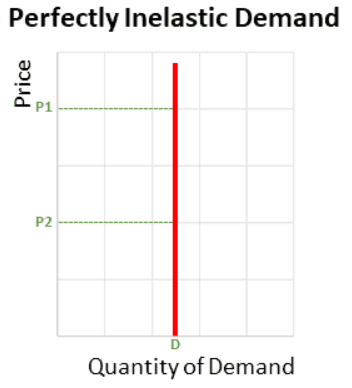

Perfectly inelastic demand implies that the quantity demanded remains constant regardless of changes in price. In other words:

- Price Insensitivity: Consumers will buy the same quantity of the product regardless of how the price changes.
- Vertical Demand Curve: The demand curve is vertical, meaning the quantity demanded is fixed, no matter the price.

It happens when there is only 1 distinct demand quantity but **various price customer paid**.

 Practical Application of Perfectly Inelastic demand:
 - Rare in practice, but indicates a product or situation where demand remains unchanged despite price variations.

####df_inelastic_demand

In [ ]:
df_inelastic_demand = spark.sql('''
    WITH product_with_one_qty AS(
      SELECT
        PRODUCT_ID,
        COUNT(DISTINCT QUANTITY) AS QTY_grpcountD,
        COUNT(QUANTITY) AS Record_count
      FROM
        fact_trans_data
      GROUP BY
        PRODUCT_ID
      HAVING
        COUNT(DISTINCT QUANTITY) = 1 AND COUNT(QUANTITY) > 1
    )

    SELECT
        PRODUCT_ID,
        QUANTITY,
        COUNT(DISTINCT Cust_paid_price) AS Price_grpcountD,
        COUNT(Cust_paid_price) AS Record_count
    FROM
        fact_trans_data
    GROUP BY
        PRODUCT_ID, QUANTITY
    HAVING
        PRODUCT_ID IN (SELECT PRODUCT_ID FROM product_with_one_qty) AND
        COUNT(DISTINCT Cust_paid_price) > 1
''')
df_inelastic_demand.show()

+----------+--------+---------------+------------+
|PRODUCT_ID|QUANTITY|Price_grpcountD|Record_count|
+----------+--------+---------------+------------+
|   1136715|     1.0|             45|          53|
|   9527048|     1.0|              3|           3|
|    839006|     1.0|              8|           8|
|    821184|     1.0|              4|          18|
|    995436|     1.0|             20|          29|
|  13416097|     1.0|              2|           3|
|    953447|     1.0|              2|           7|
|    904521|     1.0|              9|          97|
|    922610|     1.0|              3|           6|
|  13007354|     1.0|              5|          15|
|  15452302|     1.0|             11|          11|
|   9420275|     1.0|              2|           2|
|   1132036|     1.0|              8|         145|
|  10150168|     1.0|              3|           3|
|    683531|     1.0|              2|           2|
|   1026135|     1.0|              7|          40|
|    945674|     1.0|          

In [ ]:
spark.sql('''
  SELECT ROW_NUMBER() OVER (PARTITION BY QUANTITY ORDER BY Cust_paid_price) AS No, *
  FROM
  (SELECT DISTINCT * FROM fact_trans_data WHERE PRODUCT_ID == 1136715)
  ORDER BY PRODUCT_ID, Cust_paid_price
''').show(50)

+---+----------+---------------+--------+
| No|PRODUCT_ID|Cust_paid_price|QUANTITY|
+---+----------+---------------+--------+
|  1|   1136715|            0.5|     1.0|
|  2|   1136715|           0.67|     1.0|
|  3|   1136715|            0.7|     1.0|
|  4|   1136715|           0.88|     1.0|
|  5|   1136715|           0.91|     1.0|
|  6|   1136715|           0.95|     1.0|
|  7|   1136715|           0.98|     1.0|
|  8|   1136715|           0.99|     1.0|
|  9|   1136715|            1.0|     1.0|
| 10|   1136715|           1.03|     1.0|
| 11|   1136715|            1.2|     1.0|
| 12|   1136715|           1.29|     1.0|
| 13|   1136715|           1.43|     1.0|
| 14|   1136715|           1.44|     1.0|
| 15|   1136715|           1.58|     1.0|
| 16|   1136715|           1.62|     1.0|
| 17|   1136715|           1.63|     1.0|
| 18|   1136715|           1.76|     1.0|
| 19|   1136715|           1.77|     1.0|
| 20|   1136715|           1.81|     1.0|
| 21|   1136715|           1.97|  

#####Finding: 17185 records

######product_perfect_inelastic [list]

In [ ]:
product_perfect_inelastic = get_columnvalues_as_list(df_inelastic_demand,'PRODUCT_ID',1)
len(product_perfect_inelastic)

17185

In [ ]:
find_common_elements_in_list(product_perfect_inelastic, product_unknown_elasticity_0 + product_unknown_elasticity_1)

[]

###Export result

#### df_result_perfect_inelastic

In [ ]:
df_inelastic_demand.createOrReplaceTempView("inelastic_demand")

In [ ]:
df_result_perfect_inelastic = spark.sql('''
    SELECT
        PRODUCT_ID,
        0.00 AS Beta1,
        1.00 AS Beta0,
        NULL AS R2,
        AVG(Cust_paid_price) AS P_avg,
        AVG(QUANTITY) AS Q_avg,
        0.00 AS Elasticity,
        "Perfectly Inelastic" AS Demand_elasticity_type
    FROM
        fact_trans_data
    GROUP BY
        PRODUCT_ID
    HAVING
        PRODUCT_ID IN (SELECT DISTINCT PRODUCT_ID FROM inelastic_demand)

''')
df_result_perfect_inelastic.show()

+----------+-----+-----+----+------------------+-----+----------+----------------------+
|PRODUCT_ID|Beta1|Beta0|  R2|             P_avg|Q_avg|Elasticity|Demand_elasticity_type|
+----------+-----+-----+----+------------------+-----+----------+----------------------+
|   6553035| 0.00| 1.00|NULL|10.253157894736843|  1.0|      0.00|   Perfectly Inelastic|
|    897270| 0.00| 1.00|NULL|2.8353623188405797|  1.0|      0.00|   Perfectly Inelastic|
|   1115517| 0.00| 1.00|NULL|             2.992|  1.0|      0.00|   Perfectly Inelastic|
|  12352257| 0.00| 1.00|NULL|0.5685714285714286|  1.0|      0.00|   Perfectly Inelastic|
|  13115561| 0.00| 1.00|NULL|2.1541176470588237|  1.0|      0.00|   Perfectly Inelastic|
|  16809556| 0.00| 1.00|NULL| 4.390000000000001|  1.0|      0.00|   Perfectly Inelastic|
|    910558| 0.00| 1.00|NULL| 3.691999999999999|  1.0|      0.00|   Perfectly Inelastic|
|    827148| 0.00| 1.00|NULL| 9.847142857142858|  1.0|      0.00|   Perfectly Inelastic|
|    962892| 0.00| 1.

In [ ]:
df_result_perfect_inelastic.printSchema()

root
 |-- PRODUCT_ID: integer (nullable = true)
 |-- Beta1: decimal(2,2) (nullable = false)
 |-- Beta0: decimal(3,2) (nullable = false)
 |-- R2: void (nullable = true)
 |-- P_avg: double (nullable = true)
 |-- Q_avg: double (nullable = true)
 |-- Elasticity: decimal(2,2) (nullable = false)
 |-- Demand_elasticity_type: string (nullable = false)



In [ ]:
check_shape_in_df_spark(df_result_perfect_inelastic)

Shape of dataframe:
#rows: 17185
#columns: 8


In [ ]:
for c in ['Beta1', 'Beta0', 'R2','Elasticity']:
    df_result_perfect_inelastic = df_result_perfect_inelastic.withColumn(c, col(c).cast('double'))

In [ ]:
df_result_perfect_inelastic.printSchema()

root
 |-- PRODUCT_ID: integer (nullable = true)
 |-- Beta1: double (nullable = false)
 |-- Beta0: double (nullable = false)
 |-- R2: double (nullable = true)
 |-- P_avg: double (nullable = true)
 |-- Q_avg: double (nullable = true)
 |-- Elasticity: double (nullable = false)
 |-- Demand_elasticity_type: string (nullable = false)



In [ ]:
export_sparkdf_to_csv(df_result_perfect_inelastic, '/content/drive/MyDrive/DATA_SCI_SKILL/202406_CompleteJourneyProj/data set/02_DemandElasticity/', 'Result01_perfect_inelastic')

Result01_perfect_inelastic.csv has been exported successfully.


##2) Perfect Elastic Demand
Perfectly elastic demand means that consumers are willing to buy any quantity of the product at a specific price, but they will not buy the product if the price increases, even slightly. This implies:

- Zero Tolerance for Price Increase: Even a small increase in price results in the quantity demanded dropping to zero.
- Horizontal Demand Curve: The demand curve is horizontal at the price level, meaning that the price is constant regardless of the quantity demanded.

It happens when there is only 1 distinct customer-paid price  but various demand quantity (COUNT DISTINCT QTY > 1).

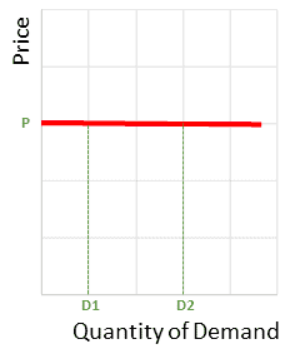

**Practical Application of Perfectly Elastic Demand:**

  While perfectly elastic demand is `largely theoretical and not observed in real-world markets`, it provides valuable insights into extreme cases of price sensitivity and helps in understanding competitive market dynamics, price setting, and consumer behavior under ideal conditions:
1. **Market Theory and Benchmarking:**

  - Perfectly elastic demand serves as a **theoretical benchmark** for understanding how **demand would behave in an idealized scenario** where consumers are incredibly sensitive to price changes.
  - It helps in modeling and **theoretical analysis of market behavior**.

2. **Price Setting and Competition:**

  - In **highly competitive markets with many sellers** offering identical products, such as in certain agricultural or commodity markets, demand might approximate perfectly elastic behavior.
  - In these cases, any price increase would lead to a complete loss of market share to competitors, reinforcing the need for **competitive pricing**.

3. **Consumer Behavior Insights:**

  - Although rare, products with near-perfect elasticity might exist in **niche markets** where any price change leads to an immediate and complete shift in demand.
  - This insight is useful for understanding scenarios where consumers are **extremely price-sensitive**.

4. **Price Discrimination and Strategic Pricing:**

  - Setting Price Floors: Understanding the concept of perfectly elastic demand can help in **setting price floors and ceilings**.
  - For products approaching perfect elasticity, businesses need to **ensure prices remain at or below the competitive equilibrium** to avoid losing all customers.

5. **Regulation and Policy Making:**
  - Policymakers can use the concept of perfectly elastic demand to **evaluate the effects of taxation or subsidies**.
  - If a market **were to exhibit near-perfect elasticity**, even `small changes in price due to policy could have significant impacts on demand`.

### df_elastic_demand

In [ ]:
df_elastic_demand = spark.sql('''
    WITH product_with_one_price AS(
      SELECT
        PRODUCT_ID,
        COUNT(DISTINCT Cust_paid_price) AS PRICE_grpcountD,
        COUNT(Cust_paid_price) AS Record_count
      FROM
        fact_trans_data
      GROUP BY
        PRODUCT_ID
      HAVING
        COUNT(DISTINCT Cust_paid_price) = 1 AND COUNT(Cust_paid_price) > 1
    )

    SELECT
        PRODUCT_ID,
        Cust_paid_price,
        COUNT(DISTINCT QUANTITY) AS QTYgrp_count_d,
        COUNT(QUANTITY) AS record_count
    FROM
        fact_trans_data
    GROUP BY
        PRODUCT_ID, Cust_paid_price
    HAVING
        PRODUCT_ID IN (SELECT PRODUCT_ID FROM product_with_one_price) AND
        COUNT(DISTINCT QUANTITY) > 1 AND COUNT(QUANTITY) > 1
    ORDER BY PRODUCT_ID, Cust_paid_price, QTYgrp_count_d
''')
df_elastic_demand.show(50)

+----------+---------------+--------------+------------+
|PRODUCT_ID|Cust_paid_price|QTYgrp_count_d|record_count|
+----------+---------------+--------------+------------+
|     25671|           3.49|             2|           3|
|     26691|           2.79|             2|           2|
|     27159|           0.27|             2|           2|
|     27951|           2.99|             2|           2|
|     30049|           1.19|             2|           2|
|     31349|           3.79|             2|           2|
|     34233|           0.99|             2|           2|
|     34601|            0.5|             2|           3|
|     34634|            0.5|             3|           4|
|     35331|            0.5|             3|           9|
|     38022|            2.0|             3|           3|
|     39839|           0.75|             2|           2|
|     40504|            2.0|             2|           2|
|     41071|           2.99|             2|           2|
|     42465|           1.09|   

In [ ]:
spark.sql('''
  SELECT ROW_NUMBER() OVER(PARTITION BY QUANTITY ORDER BY QUANTITY) AS No,*
  FROM fact_trans_data
  WHERE PRODUCT_ID == 51716
  ORDER BY PRODUCT_ID, QUANTITY
''').show(50)

+---+----------+---------------+--------+
| No|PRODUCT_ID|Cust_paid_price|QUANTITY|
+---+----------+---------------+--------+
|  1|     51716|           0.52|     1.0|
|  1|     51716|           0.52|     2.0|
|  2|     51716|           0.52|     2.0|
|  3|     51716|           0.52|     2.0|
|  4|     51716|           0.52|     2.0|
|  5|     51716|           0.52|     2.0|
|  6|     51716|           0.52|     2.0|
|  7|     51716|           0.52|     2.0|
|  8|     51716|           0.52|     2.0|
|  1|     51716|           0.52|     4.0|
|  2|     51716|           0.52|     4.0|
|  3|     51716|           0.52|     4.0|
|  4|     51716|           0.52|     4.0|
|  1|     51716|           0.52|     6.0|
|  2|     51716|           0.52|     6.0|
|  3|     51716|           0.52|     6.0|
|  4|     51716|           0.52|     6.0|
|  5|     51716|           0.52|     6.0|
|  6|     51716|           0.52|     6.0|
|  7|     51716|           0.52|     6.0|
|  8|     51716|           0.52|  

####Finding: 3819 records

##### product_perfect_elastic [list]

In [ ]:
product_perfect_elastic = get_columnvalues_as_list(df_elastic_demand,'PRODUCT_ID',1)
len(product_perfect_elastic)

3819

In [ ]:
find_common_elements_in_list(product_perfect_elastic,product_perfect_inelastic)

[]

In [ ]:
find_common_elements_in_list(product_perfect_elastic,product_unknown_elasticity)

[]

### Export result

#### df_result_perfect_elastic

In [ ]:
df_elastic_demand.createOrReplaceTempView("elastic_demand")

In [ ]:
df_result_perfect_elastic = spark.sql('''
    SELECT
        PRODUCT_ID,
        NULL AS Beta1,
        NULL AS Beta0,
        NULL AS R2,
        AVG(Cust_paid_price) AS P_avg,
        AVG(QUANTITY) AS Q_avg,
        NULL AS Elasticity,
        "Perfectly Elastic" AS Demand_elasticity_type
    FROM
        fact_trans_data
    GROUP BY
        PRODUCT_ID
    HAVING
        PRODUCT_ID IN (SELECT DISTINCT PRODUCT_ID FROM elastic_demand)

''')
df_result_perfect_elastic.show()

+----------+-----+-----+----+-------------------+------------------+----------+----------------------+
|PRODUCT_ID|Beta1|Beta0|  R2|              P_avg|             Q_avg|Elasticity|Demand_elasticity_type|
+----------+-----+-----+----+-------------------+------------------+----------+----------------------+
|  10456237| NULL| NULL|NULL|               1.69| 1.105263157894737|      NULL|     Perfectly Elastic|
|    895361| NULL| NULL|NULL|               6.99|              1.25|      NULL|     Perfectly Elastic|
|    898526| NULL| NULL|NULL|0.29999999999999993|1.4516129032258065|      NULL|     Perfectly Elastic|
|  15972711| NULL| NULL|NULL|0.39999999999999997|1.6666666666666667|      NULL|     Perfectly Elastic|
|  18005394| NULL| NULL|NULL| 1.2899999999999998|             1.125|      NULL|     Perfectly Elastic|
|    908605| NULL| NULL|NULL|               2.19|               1.3|      NULL|     Perfectly Elastic|
|  13671680| NULL| NULL|NULL|               1.29|1.3333333333333333|     

In [ ]:
check_shape_in_df_spark(df_result_perfect_elastic)

Shape of dataframe:
#rows: 3819
#columns: 8


In [ ]:
df_result_perfect_elastic.printSchema()

root
 |-- PRODUCT_ID: integer (nullable = true)
 |-- Beta1: void (nullable = true)
 |-- Beta0: void (nullable = true)
 |-- R2: void (nullable = true)
 |-- P_avg: double (nullable = true)
 |-- Q_avg: double (nullable = true)
 |-- Elasticity: void (nullable = true)
 |-- Demand_elasticity_type: string (nullable = false)



In [ ]:
for c in ['Beta1', 'Beta0', 'R2', 'Elasticity']:
    df_result_perfect_elastic = df_result_perfect_elastic.withColumn(c, col(c).cast('double'))

In [ ]:
df_result_perfect_elastic.filter(col('P_avg').isNull()).show()

+----------+-----+-----+---+-----+-----+----------+----------------------+
|PRODUCT_ID|Beta1|Beta0| R2|P_avg|Q_avg|Elasticity|Demand_elasticity_type|
+----------+-----+-----+---+-----+-----+----------+----------------------+
+----------+-----+-----+---+-----+-----+----------+----------------------+



In [ ]:
df_result_perfect_elastic.printSchema()

root
 |-- PRODUCT_ID: integer (nullable = true)
 |-- Beta1: double (nullable = true)
 |-- Beta0: double (nullable = true)
 |-- R2: double (nullable = true)
 |-- P_avg: double (nullable = true)
 |-- Q_avg: double (nullable = true)
 |-- Elasticity: double (nullable = true)
 |-- Demand_elasticity_type: string (nullable = false)



In [ ]:
export_sparkdf_to_csv(df_result_perfect_elastic, '/content/drive/MyDrive/DATA_SCI_SKILL/202406_CompleteJourneyProj/data set/02_DemandElasticity/', 'Result02_perfect_elastic')

Result02_perfect_elastic.csv has been exported successfully.


##3) Relative Elastic demand

Perform by using simple linear regression to estimate elasticity

https://openstax.org/books/introductory-business-statistics-2e/pages/13-5-interpretation-of-regression-coefficients-elasticity-and-logarithmic-transformation

The formula to estimate an elasticity when an OLS demand curve has been estimated becomes:

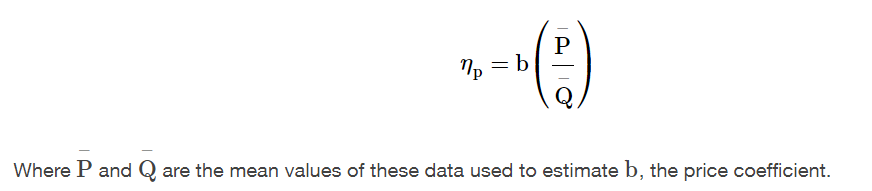

In [ ]:
#Product_id left to perform linear regression
92015-3819-17185-10323-33542

27146

###df_relative_elastic_demand

In [ ]:
df_relative_elastic_demand = df_fact_trans_data.filter(~df_fact_trans_data["PRODUCT_ID"].isin(product_unknown_elasticity + product_perfect_elastic + product_perfect_inelastic))
df_relative_elastic_demand.show()

NameError: name 'product_unknown_elasticity' is not defined

In [ ]:
df_relative_elastic_demand.printSchema()

root
 |-- PRODUCT_ID: integer (nullable = true)
 |-- Cust_paid_price: double (nullable = true)
 |-- QUANTITY: double (nullable = true)



In [ ]:
df_relative_elastic_demand.describe().show()

+-------+------------------+------------------+------------------+
|summary|        PRODUCT_ID|   Cust_paid_price|          QUANTITY|
+-------+------------------+------------------+------------------+
|  count|           2299794|           2299794|           2299794|
|   mean| 2647655.679085605| 2.220118520947005| 113.1921837347171|
| stddev|3578904.5476174816|2.1517574205883854|1224.6650790886451|
|    min|             26540|               0.0|               1.0|
|    max|          18203921|             455.0|           89638.0|
+-------+------------------+------------------+------------------+



####Finding: 27146 records

#####product_relative_elastic [list]

In [ ]:
product_relative_elastic = get_columnvalues_as_list(df_relative_elastic_demand, "PRODUCT_ID",1)
len(product_relative_elastic)

27146

######Export list

In [ ]:
# Open the file in write mode and write the list values
with open('/content/drive/MyDrive/DATA_SCI_SKILL/202406_CompleteJourneyProj/data set/02_DemandElasticity/product_relative_elastic.txt', 'w') as file:
    for item in product_relative_elastic:
        file.write(f"{item}\n")

####EDA

In [ ]:
df_relative_elastic_demand.createOrReplaceTempView("trans_relative_elastic_demand")

In [ ]:
EDA_relative_qtybyprice = spark.sql('''
  SELECT PRODUCT_ID, Cust_paid_price, COUNT(DISTINCT QUANTITY), AVG(QUANTITY), COUNT(QUANTITY) AS num_record
  FROM trans_relative_elastic_demand
  GROUP BY PRODUCT_ID, Cust_paid_price
  ORDER BY PRODUCT_ID,COUNT(DISTINCT QUANTITY) ASC
''')
EDA_relative_qtybyprice.show()

+----------+------------------+------------------------+------------------+----------+
|PRODUCT_ID|   Cust_paid_price|count(DISTINCT QUANTITY)|     avg(QUANTITY)|num_record|
+----------+------------------+------------------------+------------------+----------+
|     26540|              0.91|                       1|               2.0|         1|
|     26540|              0.97|                       1|               1.0|         1|
|     27658|              0.99|                       1|               1.0|         7|
|     27658|               1.0|                       2|               1.5|         6|
|     27658|              0.79|                       2|             1.125|         8|
|     27658|              0.88|                       2|               1.1|        10|
|     27754|              1.34|                       1|               1.0|         1|
|     27754|1.3333333333333333|                       1|               3.0|         2|
|     27754|              1.59|            

Returns only the rows with the minimum count of distinct Cust_paid_price

In [ ]:
spark.sql('''
  SELECT PRODUCT_ID, COUNT(DISTINCT Cust_paid_price) AS distinct_price_count
  FROM trans_relative_elastic_demand
  GROUP BY PRODUCT_ID
  HAVING COUNT(DISTINCT Cust_paid_price) = (
    SELECT MIN(price_count)
    FROM (
        SELECT COUNT(DISTINCT Cust_paid_price) AS price_count
        FROM trans_relative_elastic_demand
        GROUP BY PRODUCT_ID
    )
  )
  ORDER BY distinct_price_count ASC
''').show(50)

+----------+--------------------+
|PRODUCT_ID|distinct_price_count|
+----------+--------------------+
|    902024|                   2|
|   1328168|                   2|
|  10355983|                   2|
|  12384763|                   2|
|    829452|                   2|
|   6442850|                   2|
|   9368487|                   2|
|  15972688|                   2|
|   1063244|                   2|
|   1942515|                   2|
|    947784|                   2|
|  12949795|                   2|
|   1325404|                   2|
|  13911378|                   2|
|   1056071|                   2|
|    850207|                   2|
|   1082608|                   2|
|   8159433|                   2|
|   9575330|                   2|
|   1049722|                   2|
|   1100552|                   2|
|    999189|                   2|
|  13987000|                   2|
|  13777104|                   2|
|    920757|                   2|
|  15972700|                   2|
|   1737953|  

Return only the rows with the minimum count of distinct quantities

In [ ]:
spark.sql('''
  SELECT PRODUCT_ID, COUNT(DISTINCT QUANTITY) AS distinct_quantity_count
  FROM trans_relative_elastic_demand
  GROUP BY PRODUCT_ID
  HAVING COUNT(DISTINCT QUANTITY) = (
      SELECT MIN(quantity_count)
      FROM (
          SELECT COUNT(DISTINCT QUANTITY) AS quantity_count
          FROM trans_relative_elastic_demand
          GROUP BY PRODUCT_ID
      )
  )
  ORDER BY distinct_quantity_count ASC;
''').show(50)

+----------+-----------------------+
|PRODUCT_ID|distinct_quantity_count|
+----------+-----------------------+
|    937789|                      2|
|   6513703|                      2|
|   1138775|                      2|
|  12428488|                      2|
|    902024|                      2|
|   1081915|                      2|
|   1003031|                      2|
|    890604|                      2|
|    973051|                      2|
|   9552792|                      2|
|   9368487|                      2|
|  10457241|                      2|
|  13073225|                      2|
|  13189847|                      2|
|  13072680|                      2|
|   1062074|                      2|
|  15800767|                      2|
|  13007357|                      2|
|   1002431|                      2|
|    946127|                      2|
|  13213107|                      2|
|   7432030|                      2|
|   6442850|                      2|
|  12330770|                      2|
|

From overall EDA, this dataset is suitable for regression analysis as it has more than 1 price[x] where each price has various qty response[y].

### Estimate Trendline using regression model

####Import list of product_id relevant to this part [Comment this part if not run batch]

In [ ]:
#Import list (Comment this if not run batch)
with open('/content/drive/MyDrive/DATA_SCI_SKILL/202406_CompleteJourneyProj/data set/02_DemandElasticity/product_relative_elastic.txt', 'r') as file:
    # Read the entire file and split by newline characters
    content = file.read().strip()
    # Split the content by newlines to create a list
    my_list = content.split('\n')

In [ ]:
#Comment this part if not run batch
#product_relative_elastic = my_list
#len(product_relative_elastic)

27146

In [ ]:
#Comment this part if not run batch
#df_trans_agg_relative_elastic = df_fact_trans_data.filter(df_fact_trans_data["PRODUCT_ID"].isin(product_relative_elastic))

In [ ]:
#Comment this part if not run batch
#df_trans_agg_relative_elastic.createOrReplaceTempView("trans_relative_elastic_demand")

####Aggregate data for regression analysis

For analysis using simple linear regression in price[x]-demand[y] elasticity analysis, there is the assumption that each unique value of (x) MUST HAVE single corresponding value of (y). In other words, each data point has a unique (x)-(y) pair. Thus **aggregation is required**.

To perform price elasticity of demand (PED) analysis using simple linear regression, the focus will be on **how changes in price impact quantity demanded**:
- **Aggregating AVG(QTY[y]) data by each price[x]** aims to analyze how the average quantity demanded changes with price, capturing the true relationship between price and quantity, providing a more accurate estimate of price elasticity.
  - From overall statistics, there is a high standard deviation relative to the mean, indicating **considerable variability** in the data, which can `obscure the true relationship between price and quantity` if analyzed on a granular level.
  - Aggregating average quantity by price can help **smooth out the fluctuations and outliers in QTY data**, achieving a `clearer trend and better insights` into the price-quantity relationship.

**Remark:** *Aggregating average price by each fixed quantity* **is not appropriate** for estimating price elasticity of demand because:

1) **Distortion of Price-Quantity Relationship**
- Aggregating price by a fixed quantity is `not capturing variations in price [x]` that correspond to different levels of demand [y] but might end up with `misleading or less relevant average prices for each quantity`.

2) **Loss of Information due to Varied Price Points**
- Aggregating average price by a fixed quantity will **mix different price levels into a single average**, thereby `losing` detailed information about `how price changes influence quantity demanded`.

3) **Bias in Regression Analysis**
- When prices are aggregated for each fixed quantities, `the regression model may not accurately capture how price affects quantity`.
- This can result in biased estimates of price elasticity, as **the average price for each fixed quantity might not represent the true market conditions** where prices and quantities vary more dynamically.

4) **Impact on Elasticity Estimation**
- Accurate elasticity calculation requires a direct correlation between varying prices [x] and the resulting quantity [y] changes.
- Averaging prices for fixed quantities will **disorder this direct relationship**, making it d`ifficult to estimate how quantity responds to price changes`.

5) **Empirical Data Usage**
- In real-world scenarios, prices are **not uniform for each quantity** as customers may buy different quantities at different prices.
- Aggregating prices for fixed quantities does **not reflect this variability**, leading to `less accurate or less useful results for demand analysis`.

In [ ]:
df_trans_agg_relative_elastic = spark.sql('''
    SELECT PRODUCT_ID, Cust_paid_price AS P, AVG(QUANTITY) AS Q
    FROM trans_relative_elastic_demand
    GROUP BY PRODUCT_ID, Cust_paid_price
    ORDER BY PRODUCT_ID, Cust_paid_price
''')

In [ ]:
df_trans_agg_relative_elastic.show()

+----------+------------------+------------------+
|PRODUCT_ID|                 P|                 Q|
+----------+------------------+------------------+
|     26540|              0.91|               2.0|
|     26540|              0.97|               1.0|
|     27658|              0.79|             1.125|
|     27658|              0.88|               1.1|
|     27658|              0.99|               1.0|
|     27658|               1.0|               1.5|
|     27754|1.3333333333333333|               3.0|
|     27754|             1.335|               2.0|
|     27754|              1.34|               1.0|
|     27754|              1.39|               2.0|
|     27754|              1.59|               3.0|
|     27978|              4.99|               2.0|
|     27978|              5.99|               1.5|
|     27978|              6.99|3.3333333333333335|
|     28268|              0.88|               1.0|
|     28268|              0.99|               1.0|
|     28268|               1.0|

In [ ]:
df_trans_agg_relative_elastic.printSchema()

root
 |-- PRODUCT_ID: integer (nullable = true)
 |-- P: double (nullable = true)
 |-- Q: double (nullable = true)



PED measures how responsive quantity demanded is to changes in price:
- If PED > 1: Demand is elastic. A 1% increase in price leads to a more than 1% decrease in quantity demanded.
- If PED = 1: Unitary elasticity. A 1% change in price corresponds to a 1% change in quantity demanded.
- If PED < 1: Demand is inelastic. A 1% increase in price results in less than a 1% decrease in quantity demanded.

#### Run Linear Regression Model

In [ ]:
#Build dictionary to outcome values from regression model
dict_beta1 = dict()
dict_beta0 = dict()
dict_r2 = dict()
dict_pavg = dict()
dict_qavg = dict()
dict_elasticity = dict()

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

In [ ]:
print(product_relative_elastic[6788:6790])

[941012, 941033]


In [ ]:
product_relative_elastic[6790:6792]

[941036, 941051]

In [ ]:
for product_id in product_relative_elastic:
  # Filter only data by each product_id
  df_data = spark.sql(f'''
    SELECT P,Q
    FROM trans_agg_relative_elastic
    WHERE PRODUCT_ID = {product_id}
  ''')
  # Prepare data for MLlib
  assembler = VectorAssembler(inputCols=["P"], outputCol="features")
  data_transformed = assembler.transform(df_data).select(col("features"), col("Q").alias("label"))

  # Fit the Linear Regression model
  lr = LinearRegression(featuresCol="features", labelCol="label")
  lr_model = lr.fit(data_transformed)

  # Extract coefficients
  beta1 = lr_model.coefficients[0]
  beta0 = lr_model.intercept
  # Get R2 value
  r2 = lr_model.summary.r2

  # Calculate average price and quantity
  P_avg = df_data.agg(avg("P")).collect()[0][0]
  Q_avg = df_data.agg(avg("Q")).collect()[0][0]

  # Calculate elasticity
  elasticity = beta1 * (P_avg / Q_avg)

  #Store outcome values from model in dict
  dict_beta1[product_id] = beta1
  dict_beta0[product_id] = beta0
  dict_r2[product_id] = r2
  dict_pavg[product_id] = P_avg
  dict_qavg[product_id] = Q_avg
  dict_elasticity[product_id] = elasticity

In [ ]:
dict_elasticity

{'26540': -10.444444444442565,
 '27658': 0.6096413874191716,
 '27754': 2.434954272297792,
 '27978': 1.7531707317072946,
 '28268': 3.5065789473686957}

In [ ]:
df_result_relative_elastic = pd.DataFrame(product_relative_elastic[0:5+1], columns=['PRODUCT_ID'])
df_result_relative_elastic["Beta1"] = df_result_relative_elastic['PRODUCT_ID'].map(dict_beta1)
df_result_relative_elastic["Beta0"] = df_result_relative_elastic['PRODUCT_ID'].map(dict_beta0)
df_result_relative_elastic["R2"] = df_result_relative_elastic['PRODUCT_ID'].map(dict_r2)
df_result_relative_elastic["P_avg"] = df_result_relative_elastic['PRODUCT_ID'].map(dict_pavg)
df_result_relative_elastic["Q_avg"] = df_result_relative_elastic['PRODUCT_ID'].map(dict_qavg)
df_result_relative_elastic["Elasticity"] = df_result_relative_elastic['PRODUCT_ID'].map(dict_elasticity)

In [ ]:
df_result_relative_elastic.head()

,PRODUCT_ID,Beta1,Beta0,R2,P_avg,Q_avg,Elasticity,Demand_elasticity_type
0,26540,-16.666667,17.166667,1.000000,0.940000,1.500000,-10.444444,Highly Elastic
1,27658,0.787037,0.461111,0.127563,0.915000,1.181250,0.609641,Inelastic
2,27754,3.832745,-3.156899,0.254147,1.397667,2.200000,2.434954,Elastic (Positive)
3,27978,0.666667,-1.715556,0.494845,5.990000,2.277778,1.753171,Elastic (Positive)
4,28268,4.887218,-3.342105,0.317669,0.956667,1.333333,3.506579,Elastic (Positive)


###Categorize demand elasticity type

For practical applications like pricing strategies and revenue predictions, the magnitude of elasticity is more relevant than its direction. Absolute values give a clearer idea of how much demand will change in response to price adjustments, which is crucial for strategic decisions.
- Positive Elasticity:
    - Uncommon, where demand increases as price increases.
    - In some cases, like with Giffen goods, speculative markets or certain luxury items, higher prices might lead to higher demand.
- Negative Elasticity:
    - Most common, where demand decreases as price increases.
    - This is the standard case where price increases lead to reduced demand.
- Inelastic (Positive):
    - Products with a positive elasticity between 0 and 1 see a smaller increase in demand relative to price increases.
    - This scenario is rare but can occur in markets with certain consumer behaviors or expectations.

The elasticity values can be categorized into different types:
1. **Highly Elastic:** Elasticity < -1

    - Interpretation: Demand is highly sensitive to price changes.
    - A 1% increase in price leads to a decrease in quantity demanded by more than 1%.
    - Practical Application:
      - Products that experience significant changes in demand with small price changes.
      - Useful for determining when price cuts can lead to substantial increases in sales.

2. **Elastic:** -1 < Elasticity < 0

    - Interpretation: Demand is moderately sensitive to price changes.
    - A 1% increase in price leads to a decrease in quantity demanded by less than 1% but more than 0%.
    - Practical Application:
      - Products with moderate sensitivity to price changes.
      - Pricing strategies should consider the moderate response to price adjustments.

3. **Unitary Elastic:** Elasticity = -1 or 1

    - Interpretation: Demand changes proportionately with price changes.
    - A 1% increase in price results in a 1% decrease or increase in quantity demanded.
    - Practical Application:
      - Products where total revenue remains constant when the price changes.
      - Price changes won't affect total revenue.

4. **Inelastic:** 0 < Elasticity < 1

    - Interpretation: Demand is less sensitive to price changes.
    - A 1% increase in price leads to a less than 1% increase in quantity demanded.
    - Practical Application:
      - Products where demand is relatively stable despite price changes.
      - These are often necessities or products with fewer substitutes.

5. **Elastic (Positive):** Elasticity > 1

    - Interpretation: Demand increases significantly with price.
    - This is less common in typical demand scenarios.
    - Practical Application:


In [ ]:
# Function to categorize elasticity
def categorize_elasticity(elasticity):
    if elasticity < -1:
        return 'Highly Elastic'
    elif -1 < elasticity < 0:
        return 'Elastic (Negative)'
    elif elasticity == -1 or elasticity == 1:
        return 'Unitary Elastic'
    elif 0 < elasticity < 1:
        return 'Inelastic'
    elif elasticity > 1:
        return 'Elastic (Positive)'
    else:
        return 'Unknown'

In [ ]:
df_result_relative_elastic['Demand_elasticity_type'] = df_result_relative_elastic['Elasticity'].apply(categorize_elasticity)
df_result_relative_elastic.head()

,PRODUCT_ID,Beta1,Beta0,R2,P_avg,Q_avg,Elasticity,Demand_elasticity_type
0,26540,-16.666667,17.166667,1.000000,0.940000,1.500000,-10.444444,Highly Elastic
1,27658,0.787037,0.461111,0.127563,0.915000,1.181250,0.609641,Inelastic
2,27754,3.832745,-3.156899,0.254147,1.397667,2.200000,2.434954,Elastic (Positive)
3,27978,0.666667,-1.715556,0.494845,5.990000,2.277778,1.753171,Elastic (Positive)
4,28268,4.887218,-3.342105,0.317669,0.956667,1.333333,3.506579,Elastic (Positive)


#####Sample of Interpreting the Values

**Product_ID = 26540: Elasticity = -10.444444444442565**
- A negative elasticity value indicates that the quantity demanded decreases as the price increases.
- In this case, a price increase would lead to a significant decrease in quantity demanded.
- An elasticity of -10.44 suggests that the product is highly elastic; a 1% increase in price would lead to a 10.44% decrease in quantity demanded.

**Product_ID =  27658: Elasticity = 0.6096413874191716**
- A positive elasticity value indicates that the quantity demanded increases as the price increases.
- This can be less common in typical demand scenarios but may apply to Veblen goods or luxury items.
- An elasticity of 0.61 means that a 1% increase in price would lead to a 0.61% increase in quantity demanded.

###Export Result

In [ ]:
export_pandasdf_to_csv(df_result_relative_elastic, '/content/drive/MyDrive/DATA_SCI_SKILL/202406_CompleteJourneyProj/data set/02_DemandElasticity/', 'Result03_relative_elastic')

Result03_relative_elastic.csv has been exported successfully.
